In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
from mppi.Utilities import Constants as Const
from mppi.Utilities import Tools
import matplotlib.pyplot as plt
import numpy as np
import os, yaml

h_red = Const.Planck_reduced_ev_ps*1e3 # hbar in eV*fs
h = Const.Planck_ev_ps*1e3 # h in eV*fs

In [ ]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.YamboCalculator(rr)
#code.global_options()

In [13]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',time='11:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.YamboCalculator(rr,activate_BeeOND=True) #,skip=False,clean_restart=False
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 16,
 'cpus_per_task': 2,
 'omp_num_threads': 2,
 'gpus_per_node': None,
 'memory': '125000',
 'time': '11:59:00',
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

# Computation of the IP Absorption spectrum

We compute the IP absorption spectrum using Yambo

In [6]:
# analysis with k sampling volume of 0.06 (1000 points)     
run_dir = 'ABS-IP'
source_dir = 'DFT_analysis/kpoints_42-nbnds_250.save/'

In [8]:
Tools.build_SAVE(source_dir,run_dir)

Create folder ABS-IP
Executing command: cd DFT_analysis/kpoints_42-nbnds_250.save/; p2y
Create a symlink of /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/MoS2/DFT_analysis/kpoints_42-nbnds_250.save/SAVE in ABS-IP
Executing command: cd ABS-IP; yambo


DFT gap is equal to 1.78 eV, we add a scissor to reproduce the _experimental value_ set to 2.4 eV
in agreemnent with the results of PHYSICAL REVIEW B 88, 045412 (2013)

In [71]:
eta = 0.1 # energy broadening in eV
dft_gap = 1.78
exp_gap = 2.4
scissor = exp_gap-dft_gap # eV

inp = I.YamboInput('yambo -o c',folder=run_dir)
inp['variables']['LongDrXd'] = [[1.00,1.00,0.00],''] # electric field
inp['variables']['XfnQP_E'] = [[scissor,1.00,1.00],''] # scissor
inp['variables']['DmRngeXd'] = [[eta/2,eta/2],'eV'] # damping range
inp['variables']['EnRngeXd'] = [[0,8],'eV'] # energy range
inp['variables']['ETStpsXd'] = [1000,''] # number of energy step
inp['variables']['BndsRnXd'] = [[22,29],''] # bands used for transitions
inp['variables']['QpntsRXd'] = [[1,1],''] # momentum transfer
inp

{'args': 'yambo -o c',
 'folder': 'ABS-IP',
 'filename': 'yambo.in',
 'arguments': ['chi', 'optics'],
 'variables': {'DIP_Threads': [0.0, ''],
  'X_Threads': [0.0, ''],
  'ETStpsXd': [1000, ''],
  'Chimod': 'IP',
  'QpntsRXd': [[1, 1], ''],
  'BndsRnXd': [[22, 29], ''],
  'EnRngeXd': [[0, 8], 'eV'],
  'DmRngeXd': [[0.05, 0.05], 'eV'],
  'LongDrXd': [[1.0, 1.0, 0.0], ''],
  'XfnQP_E': [[0.6199999999999999, 1.0, 1.0], '']}}

In [52]:
name = 'ip_abs'
results = code.run(input=inp,run_dir=run_dir,name=name,skip=False)
results

delete job_out script: ABS-IP/job_ip_abs.out
delete folder: ABS-IP/ip_abs
run command: mpirun -np 16 yambo -F ip_abs.in -J ip_abs -C ip_abs
slurm submit:  cd ABS-IP ; sbatch job_ip_abs.sh
computation ip_abs is running...
computation ip_abs ended
Run performed in 26s


{'output': {'eps_q1_ip': 'ABS-IP/ip_abs/o-ip_abs.eps_q1_ip',
  'eel_q1_ip': 'ABS-IP/ip_abs/o-ip_abs.eel_q1_ip'},
 'report': 'ABS-IP/ip_abs/r-ip_abs_optics_dipoles_chi',
 'dft': 'ABS-IP/SAVE/ns.db1',
 'dipoles': 'ABS-IP/ip_abs/ndb.dipoles'}

In [72]:
data = P.YamboParser(results)
eps = data.data['eps_q1_ip']
energy = eps['col0']
eps_im = eps['col1']
eps_re = eps['col2']

(-1.0, 11.0)

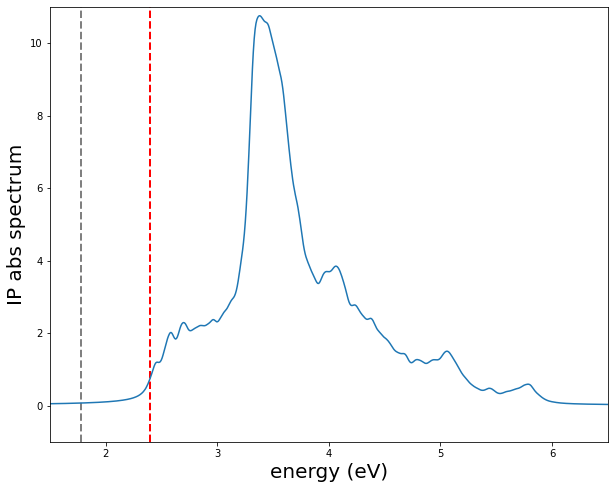

In [73]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(energy,eps_im)
ax.vlines(dft_gap,-1,11,linestyles='--',color='gray',linewidth=2)
ax.vlines(exp_gap,-1,11,linestyles='--',color='red',linewidth=2)
ax.set_ylabel('IP abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.set_xlim(1.5,6.5)
ax.set_ylim(-1,11)